## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 installation

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.1 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets albumentations

Liveloss plot utility to watch train/validation loss in realtime

In [ ]:
!pip install livelossplot --quiet

In [ ]:
!pip install onedrivedownloader nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.2 imports

In [ ]:
# imports

import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

from datasets import load_dataset

from transformers import MaskFormerImageProcessor
from transformers import MaskFormerForInstanceSegmentation
import torchvision.transforms.functional as TF

import albumentations as A

from onedrivedownloader import download
import os
import nibabel as nib

# additional utils
from tqdm.auto import tqdm
from livelossplot import PlotLosses
# from google.colab import files

np.set_printoptions(precision=16)  

NOTE: Redirects are currently not supported in Windows or MacOs.


### 1.3 environmental variables

In [ ]:
# create a data directory and set some variables
!mkdir data

DATA_DIR = 'data'
IMG_SEGM_DIR = os.path.join(DATA_DIR, "images_segm")
IMG_STRUCT_DIR = os.path.join(DATA_DIR, "images_structural")
IMG_REDUCED_DIR = os.path.join(DATA_DIR, "images_annot_reduced")
IMG_AUTO_SEGM_DIR = os.path.join(DATA_DIR, "automated_segm")
IMG_AUTO_SEGM_REDUCED_DIR = os.path.join(DATA_DIR, "automated_segm_reduced")

STRUCT_SCANS = ["T1", "T2", "T1GD", "FLAIR"]

A subdirectory or file data already exists.


In [ ]:
IMAGES_SEGM_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EbmrLEe1ZgpNkaujtMtlDIEB9rQ0Zj82dOWIttA8sD5lSg"
IMAGES_SEGM_FNAME = "images_segm.zip" 

IMAGES_STRUCTURAL_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ER8oOEAm1ANGlK4sodUPdX0B6_7IxmbRoneyo-RXI2HYOg"
IMAGES_STRUCTURAL_FNAME = "images_structural.zip"

IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EfqrvokObOJEhovsqLl_sscBgplo836OUdN5kJzAYqPZyg"
IMAGES_ANNOT_REDUCED_FNAME = "images_annot_reduced.zip"

IMAGES_AUTO_SEGM_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EToY-Cli4vxMqYwHx_NZ4JsBi1Lo8tOskj9zb4_AZmDfcg"
IMAGES_AUTO_SEGM_FNAME = "automated_segm.zip"

IMAGES_AUTO_SEGM_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EXwqKvC8QpBBjFQUXzKR1-IBtJeP1hwXUQAoJOneJx4-Hw"
IMAGES_AUTO_SEGM_REDUCED_FNAME = "automated_segm_reduced.zip"

### 1.4 General functions

In [ ]:
# helper functions

##
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

## get mask
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

## random split data based on subjects
def split_subjects(input_list, split_ratio=0.8, seed=0):
    random.seed(seed)
    
    # get the number of indice for output files
    n_data = len(input_list)
    n1 = round(n_data*split_ratio)
    n2 = n_data - n1

    # get the list of indice for output files
    output_list_1 = random.sample(input_list, n1)
    output_list_2 = [data for data in input_list if data not in output_list_1]

    return output_list_1, output_list_2

## randomly split data (index file) with given ratio
def split_data_index(input_fn, output_fn_1, output_fn_2, split_ratio=0.8, seed=0):
    random.seed(seed)

    index_in = []
    # get the list of index from file
    with open(input_fn, 'r') as file:
        for line in file:
            index_in.append(line.strip())

    # get the number of indice for output files
    n_data = len(index_in)
    n1 = round(n_data*split_ratio)
    n2 = n_data - n1

    # get the list of indice for output files
    index_out_1 = random.sample(index_in, n1)
    index_out_2 = [idx for idx in index_in if idx not in index_out_1]

    # write output files
    with open(output_fn_1, 'w') as file:
        for item in index_out_1:
            file.write("%d\n" % int(item))

    with open(output_fn_2, 'w') as file:
        for item in index_out_2:
            file.write("%d\n" % int(item))

## calculate mIoU
def compuate_mIoU(mask_pred, mask_true):
    num_i = len( np.where(mask_pred * mask_true != 0)[0] )
    num_u = len( np.where(mask_pred + mask_true != 0)[0] )
    mIoU = num_i / num_u * 100
    return mIoU, num_u

## define how to load individual data
def obtain_data(dir, index_list, index, convert_rgb=False):

    data_exact = {}

    with open(dir+'/'+index_list, 'r') as file:
        num_lines = sum(1 for line in file)
    
    if index >= num_lines:
        print("warning: given index",index,"does not exist in data. Try different index.")
        return None

    with open(dir+'/'+index_list, 'r') as file:
        for line_number, line_content in enumerate(file):
            if line_number == index:
                file_no = str(line_content).strip()

    if convert_rgb:
      data_exact['image'] = Image.open(dir+"/image"+file_no+".jpg").convert("RGB")
    else:
      data_exact['image']       = Image.open(dir+"/image"+file_no+".jpg")
    data_exact['image']       = ImageOps.exif_transpose(data_exact['image']) # handle rotation correctly
    data_exact['annotation']  = Image.open(dir+"/annot"+file_no+".png")
    data_exact['index2label'] = torch.load(dir+"/index2label"+file_no+".pt")

    return data_exact


### 1.5 Data loaders
We define here how to organize data into the input format for maskformer

In [ ]:
# Dataloader for the MRI dataset
class CustomMRIDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, data_dir, data_list_fn, processor, transform=None, augment=None):
        """
        Args:
            dataset
        """
        self.datadir = data_dir
        self.data_list_fn = data_list_fn
        self.processor = processor
        self.transform = transform
        self.augment = augment
        with open(data_list_fn, 'r') as file:
             self.n_data = sum(1 for line in file)
        
    def __len__(self):
        return self.n_data
    
    def __getitem__(self, idx):

        if idx >= self.n_data:
            print("warning: given index",idx,"does not exist in data. Using firs sample instead.")

        with open(self.data_list_fn, 'r') as my_file:
            for line_number, line_content in enumerate(my_file):
                # load the first line as default
                if line_number == 0:
                    subj_no = line_content.split('.')[0].split('_')[0]
                    file_no = line_content.split('.')[0].split('_')[1]
                # set numbers according to idx
                if line_number == idx:
                    subj_no = line_content.split('.')[0].split('_')[0]
                    file_no = line_content.split('.')[0].split('_')[1]

        data_file_0 = subj_no + '_11_FLAIR_' + str(file_no) + '.nii.gz'
        data_file_1 = subj_no + '_11_T1_'    + str(file_no) + '.nii.gz'
        data_file_2 = subj_no + '_11_T1GD_'  + str(file_no) + '.nii.gz'
        label_file  = subj_no + '_11_segm_'  + str(file_no) + '.nii.gz'

        # load data file
        data_cur = nib.load(os.path.join(self.datadir, data_file_0))
        n_h = data_cur.shape[0]
        n_w = data_cur.shape[1]
        image = np.zeros( (n_h, n_w, 3) )

        image[:,:,0] = data_cur.get_fdata()

        data_cur = nib.load(os.path.join(self.datadir, data_file_1))
        image[:,:,1] = data_cur.get_fdata()

        data_cur = nib.load(os.path.join(self.datadir, data_file_2))
        image[:,:,2] = data_cur.get_fdata()

        # load segm file
        instance_seg =  np.zeros( (n_h, n_w) )
        data_cur = nib.load(os.path.join(self.datadir, label_file))
        instance_seg[:,:] = data_cur.get_fdata().astype('uint')

        # currently set mapping manually
        mapping_dict = {}
        mapping_dict[0] = 0
        mapping_dict[1] = 1
        mapping_dict[2] = 2
        mapping_dict[4] = 4

        # Use NumPy's vectorize() function to apply the mapping function to each element in the original array
        class_id_map = np.vectorize(lambda x: mapping_dict[x])(instance_seg)
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.augment is True:

            # convert to C, H, W (torchvision transforms assume this shape)
            image = image.transpose(2,0,1)
            n1_tmp = instance_seg.shape[0]
            n2_tmp = instance_seg.shape[1]
            instance_seg = instance_seg.reshape((1,n1_tmp,n2_tmp))

            #do more data augmentation when images are converted to tensors
            image = torch.from_numpy(image)
            instance_seg = torch.from_numpy(instance_seg)
            
            # Apply random horizontal flip to image and mask
            if np.random.random() > 0.5:
                image = TF.hflip(image)
                instance_seg = TF.hflip(instance_seg)
            
            # # Apply random brightness and saturation to image
            # bf1 = random.random()*(1.2 - 0.8) + 0.8
            # image = TF.adjust_brightness(image, bf1)

            # bf1 = random.random()*(1.2 - 0.8) + 0.8
            # image = TF.adjust_saturation(image, bf1)

            # Apply random crop to both the image and mask (as tensors)
            factor1 = 0.8
            if random.random() > 0.5:
                chance1 = random.choice([0,1,2,3])
                dim1 = image.shape
                # print('Original image dimension:',dim1,'choice:',chance1)
                if chance1 == 0: #upper left
                    image        =        image[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                elif chance1 == 1: #upper right
                    image        =        image[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                elif chance1 == 2: #lower right
                    image        =        image[:,int(dim1[1]*(1-factor1)):,int(dim1[1]*(1-factor1)):]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                else: #lower left
                    image        =        image[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
            
            # # Apply random rotation to image and mask
            # if random.random() > 0.5:
            #     angle1 = random.randint(-30, 30)
            #     scale1 = random.random()*(1.2 - 0.8) + 0.8
            #     image = TF.affine(image, angle=angle1, translate=[0.0,0.0], scale=scale1, shear=0.0)
            #     instance_seg = TF.affine(instance_seg, angle=angle1, translate=[0.0,0.0], scale=scale1, shear=0.0)

            #change back to ndarray
            image = image.numpy()
            instance_seg = instance_seg.numpy()
            instance_seg = instance_seg[0,:,:]

            # convert to H, W, C (transform requires this)
            image = image.transpose(1,2,0)

            # # remove labels not in the transformed segmentation map
            # inst_remove = {}
            # for instance in inst2class.keys():
            #     if not np.any(np.isin(instance_seg, instance)):
            #         inst_remove[instance] = 0
            # inst2class_new = {k: v for k, v in inst2class.items() if k not in inst_remove}
            # inst2class.update(inst2class_new)

            # # handle possible instance 0 that is created in transform
            # if instance_seg.min() == 0 and 0 not in inst2class:
            #     inst2class[0] = 0

            # print("inst2class after transform  :", inst2class)
            # print("instance_seg after transform:", np.unique(instance_seg))

        #final resizing to get in proper format for model (correct for cropping)
        transformed = self.transform(image=image, mask=instance_seg)
        image, instance_seg = transformed['image'], transformed['mask']

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

### Display functions

In [ ]:
def get_img_path(subj_file, struct_scan=None, segm=False, auto_segm=False, reduced=False):
  '''
    Description: Constructs the file name and directory for the image file depending on supplied parameters
    Args:
        struct_scan: specify type of scan to be loaded: T1, T2, T1GD, FLAIR
        segm: If true, load the manually annotated image. if struct_scan is not None, this will be overriden 
              and the structural image will be loaded instead
        auto_segm: If true, load the auto-labeled segmented image
        reduced: If true, load the reduced version of the specified image type. This parameter can be true for any image
              
    Returns: file name and file path
  '''
  # assert that struct_scan should be specified if we are not loading the labelled/segmented images
  if segm == False and auto_segm == False:
    assert struct_scan is not None, f'Specify which struct scan {STRUCT_SCANS} if both segm and auto_segm is False'

  # assert that image cannot be both manual and auto-labelled
  if segm == True and auto_segm == True:
    assert auto_segm == False, 'Can only select either segmented or auto-segmented'

  f_name = f"{subj_file}"
  f_dir = ""

  # build file name and supply the file path based on current onedrive folder structure
  if struct_scan is not None:
    f_name = f"{f_name}_{struct_scan}"
    f_dir = os.path.join(IMG_STRUCT_DIR, subj_file)
  
  if segm:
    f_name = f"{f_name}_segm"
    f_dir = IMG_SEGM_DIR

  if auto_segm:
    f_name = f"{f_name}_automated_approx_segm"
    f_dir = IMG_AUTO_SEGM_DIR

  if reduced:
    f_name = f"{f_name}_cut"
    f_dir = IMG_AUTO_SEGM_REDUCED_DIR if auto_segm==True else IMG_REDUCED_DIR
    
  f_name = f"{f_name}.nii.gz"
  f_path = os.path.join(f_dir, f_name)
  return f_name, f_path

def load_nifti_img(subj_file, struct_scan=None, segm=False, auto_segm=False, reduced=False, dtype=None):
    '''
      Args:
        subj_file: e.g. UPENN-GBM-00001_11
        struct_scan: T1, T2, T1GD, FLAIR
        dtype: e.g. uint. default is float64 if none is supplied

      Description: Loads nifti file depending on supplied parameters
      Returns: file name and loaded image
    '''
    f_name, f_path = get_img_path(subj_file, struct_scan=struct_scan, segm=segm, auto_segm=auto_segm, reduced=reduced)
    nifti = nib.load(f_path)
    img_data = None
    
    if dtype is not None:
      img_data = nifti.get_fdata().astype(dtype)
    else:
      img_data = nifti.get_fdata()
    return f_name, img_data

def plot_struct_img(img_data, fig, axs, row, col, title=None, cmap="Greys_r", auto_cbar=True, alpha_mask=None):
    '''
      Args:
        img_data: loaded nifti file
        auto_bar: add the color bar if true
        
      Returns: Plotted image
    '''

    # TODO: add slice idx as parameter. For now, use the slice with the largest tumor
    nonzero_counts = np.sum(np.count_nonzero(img_data, axis=0), axis=0 )
    slice_idx = np.argmax(nonzero_counts)

    alpha = None
    if alpha_mask is not None:
       alpha = alpha_mask[:, :, slice_idx]

    img = axs[row, col].imshow(img_data[:, :, slice_idx], aspect='equal', cmap=cmap, alpha=alpha)
    if title:
      axs[row, col].set_title(title)
    if auto_cbar:
      fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    return img

def plot_segm_img(img_data, fig, axs, row, col, title=None, cmap="turbo", auto_cbar=False, overlay=False):
  
  # TODO: add slice idx as parameter. For now, use the slice with the largest tumor
  nonzero_counts = np.sum(np.count_nonzero(img_data, axis=0), axis=0 )
  slice_idx = np.argmax(nonzero_counts)

  alpha_mask = None
  if overlay==True:
    cmap = "gnuplot"
    alpha_mask = np.where(img_data == 0, 0, 0.4)

  # calculate a discrete colorbar for the labels
  # get label names only from the slice being displayed
  label_names = np.unique(img_data[:, :, slice_idx])
  label_cmap = plt.get_cmap(cmap, len(label_names))

  # re-use plot_struct_img but make auto cbar=false since we have to manually build the discrete color bar later
  img = plot_struct_img(img_data, fig, axs, row, col, title, cmap=label_cmap, auto_cbar=auto_cbar, alpha_mask=alpha_mask)

  # build the color bar
  if auto_cbar == False:
    cbar = fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    ticks = np.linspace(np.min(label_names), np.max(label_names)-1, len(label_names))
    cbar.set_ticks(ticks + 0.5)
    cbar.set_ticklabels(label_names)

# temporary plotting functions, to be replaced by new plot_struct_img() and plot_segm_img() when they are ready
def plot_struct_img2d(img_data, fig, axs, row, col, title=None, cmap="Greys_r", auto_cbar=True, alpha_mask=None):
    '''
      Args:
        img_data: loaded nifti file
        auto_bar: add the color bar if true
        
      Returns: Plotted image
    '''

    alpha = None
    if alpha_mask is not None:
       alpha = alpha_mask[:, :]

    img = axs[row, col].imshow(img_data[:, :], aspect='equal', cmap=cmap, alpha=alpha)
    if title:
      axs[row, col].set_title(title)
    if auto_cbar:
      fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    return img

def plot_segm_img2d(img_data, fig, axs, row, col, title=None, cmap="turbo", auto_cbar=False, overlay=False):

  alpha_mask = None
  if overlay==True:
    cmap = "gnuplot"
    alpha_mask = np.where(img_data == 0, 0, 0.4)

  # calculate a discrete colorbar for the labels
  # get label names only from the slice being displayed
  label_names = np.unique(img_data[:, :])
  label_cmap = plt.get_cmap(cmap, len(label_names))

  # re-use plot_struct_img but make auto cbar=false since we have to manually build the discrete color bar later
  img = plot_struct_img2d(img_data, fig, axs, row, col, title, cmap=label_cmap, auto_cbar=auto_cbar, alpha_mask=alpha_mask)

  # build the color bar
  if auto_cbar == False:
    cbar = fig.colorbar(img, ax=axs[row, col], fraction=0.05)
    ticks = np.linspace(np.min(label_names), np.max(label_names)-1, len(label_names))
    cbar.set_ticks(ticks + 0.5)
    cbar.set_ticklabels(label_names)


## 2. Process 2D data

### 2.1 load and QC 2D data

In [ ]:
# download 2D training and validation data
# depth slices
data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ESjuFGcpIBVDmrN26bbLVOQBddsUotkaxEK6EmaSu1sY8Q?e=AaO8Ln"
data_train_2d_fname = "train_2d.zip" 
data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EbW8MIQ4emtEvooEjMSThgwBm8HV_AGivf9ZA7SOlsE4BQ?e=m28iow"
data_val_2d_fname = "val_2d.zip" 

# cross section slices
# data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EYZPY3tWsJJJtylgsV4D2o4BRXOY0VvCmAVwKwMB2-LnsA?e=83nPSi"
# data_train_2d_fname = "train_2d_cross.zip" 
# data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ETwIE-ebA6lOr2qNaAct2twBTsjqS7SnOkdfJZ7B4rU3QQ?e=v4U6d9"
# data_val_2d_fname = "val_2d_cross.zip" 

download(data_train_2d, filename=os.path.join('./', data_train_2d_fname))
download(data_val_2d,   filename=os.path.join('./', data_val_2d_fname))

100%|██████████████████████████████████████████████████████████████████████████████| 929M/929M [01:38<00:00, 9.39MiB/s]


Unzipping file...


Extracting files: 100%|████████████████████████████████████████████████████████| 71721/71721 [00:44<00:00, 1595.48it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 314M/314M [00:27<00:00, 11.4MiB/s]


Unzipping file...


Extracting files: 100%|████████████████████████████████████████████████████████| 24451/24451 [00:14<00:00, 1673.78it/s]


'.'

### 2.2 make a data list file

Using below if use all data

In [ ]:
# train_dir = 'data/train_2d_cross'
# val_dir   = 'data/val_2d_cross'
# train_data_list_fn = train_dir + "/data_train.txt"
# val_data_list_fn   = val_dir   + "/data_val.txt"

In [ ]:
# # obtain data list

# # obtain unique samples
# train_files = os.listdir(train_dir)
# train_files.sort()
# train_files_unique = []
# for my_file in train_files:
#     if my_file.split('.')[-1] == 'gz':
#         train_files_unique.append(my_file.split('_')[0] + "_" + my_file.split('_')[3])
# train_files_unique = list(set(train_files_unique))
# train_files_unique.sort()
# print(f"Number of unique training samples: {len(train_files_unique)}")

# # write sample names to file
# with open(train_data_list_fn, 'w') as f:
#     for item in train_files_unique:
#         f.write("%s\n" % item)

# # obtain unique samples
# val_files = os.listdir(val_dir)
# val_files.sort()
# val_files_unique = []
# for my_file in val_files:
#     if my_file.split('.')[-1] == 'gz':
#         val_files_unique.append(my_file.split('_')[0] + "_" + my_file.split('_')[3])
# val_files_unique = list(set(val_files_unique))
# val_files_unique.sort()
# print(f"Number of unique validation samples: {len(val_files_unique)}")

# # write sample names to file
# with open(val_data_list_fn, 'w') as f:
#     for item in val_files_unique:
#         f.write("%s\n" % item)

Number of unique training samples: 14344
Number of unique validation samples: 4890


Using below if using part of the data only (slices near center)

In [ ]:
train_dir = 'data/train_2d'
val_dir   = 'data/val_2d'
train_data_list_c_fn = train_dir + "/data_train.txt"
val_data_list_c_fn   = val_dir   + "/data_val.txt"

# obtain data list
n_total = 146

# obtain unique samples
train_files = os.listdir(train_dir)
train_files.sort()
train_files_unique_c = []
for my_file in train_files:
    if my_file.split('.')[-1] == 'gz':
        file_no = int(my_file.split('.')[0].split('_')[-1])
        if file_no >= n_total // 4 and file_no < n_total // 4 * 3: 
            train_files_unique_c.append(my_file.split('_')[0] + "_" + my_file.split('_')[3])

train_files_unique_c = list(set(train_files_unique_c))
train_files_unique_c.sort()
print(f"Number of unique training samples: {len(train_files_unique_c)}")

# write sample names to file
with open(train_data_list_c_fn, 'w') as f:
    for item in train_files_unique_c:
        f.write("%s\n" % item)

# obtain unique samples
val_files = os.listdir(val_dir)
val_files.sort()
val_files_unique_c = []
for my_file in val_files:
    if my_file.split('.')[-1] == 'gz':
        file_no = int(my_file.split('.')[0].split('_')[-1])
        if file_no >= n_total // 4 and file_no < n_total // 4 * 3: 
            val_files_unique_c.append(my_file.split('_')[0] + "_" + my_file.split('_')[3])

val_files_unique_c = list(set(val_files_unique_c))
val_files_unique_c.sort()
print(f"Number of unique validation samples: {len(val_files_unique_c)}")

# write sample names to file
with open(val_data_list_c_fn, 'w') as f:
    for item in val_files_unique_c:
        f.write("%s\n" % item)

Number of unique training samples: 6336
Number of unique validation samples: 2160


### 2.3 Create Custom PyTorch Dataset


In [ ]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [ ]:
# create train/validation datasets

# use the same mean and std as training set
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# define data transoforms
train_transform = A.Compose([
    A.Resize(width=146, height=193),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# create datasets
# train_dataset = CustomMRIDataset(train_dir, data_list_fn=train_data_list_fn, processor=processor, transform=train_transform, augment=True)
# val_dataset   = CustomMRIDataset(val_dir, data_list_fn=val_data_list_fn,     processor=processor, transform=train_transform, augment=False)
train_dataset = CustomMRIDataset(train_dir, data_list_fn=train_data_list_c_fn, processor=processor, transform=train_transform, augment=True)
val_dataset   = CustomMRIDataset(val_dir, data_list_fn=val_data_list_c_fn,     processor=processor, transform=train_transform, augment=False)

In [ ]:
# setup data loader
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
id2label = {}
id2label[0] = 'else'
id2label[1] = 'NCR'
id2label[2] = 'ED'
id2label[4] = 'ET'
id2label

{0: 'else', 1: 'NCR', 2: 'ED', 4: 'ET'}

### Visualize data and annotation

In [ ]:
# load data list file
val_list = torch.load('val_list.py')

(193, 146)
(193, 146)
(193, 146)
(193, 146)
(193, 146)
(193, 146)
(193, 146)
(193, 146)
(193, 146)
(193, 146)
(193, 146)


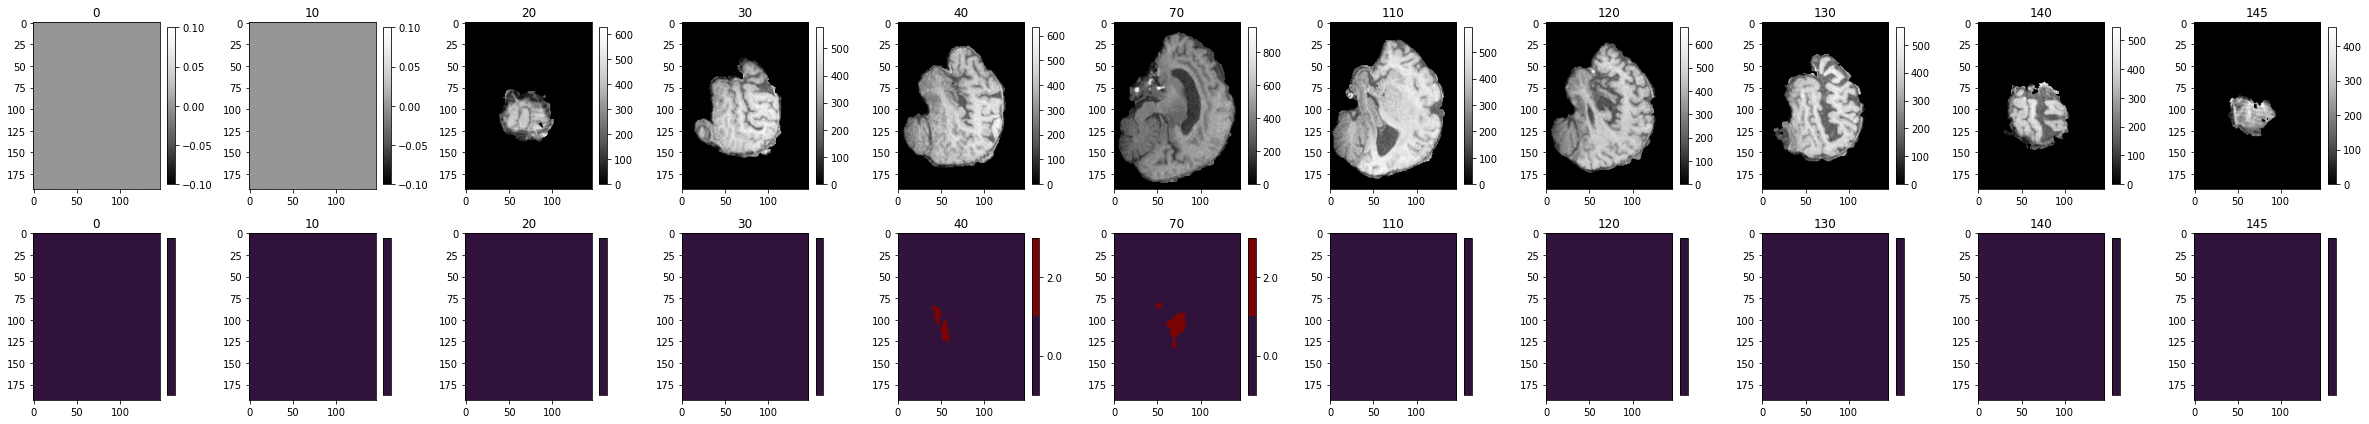

In [ ]:
subj_file = val_list[1]
struct_scan = STRUCT_SCANS[0]
data_dir = 'data/val_2d_cross'
indices = [0,10,20,30,40,70,110,120,130,140,145]

# plot struct and corresponding reduced images
fig, axs = plt.subplots(nrows=2, ncols=len(indices), figsize=(3*len(indices), 3*2))
for idx, islice in enumerate(indices):

    nifti_file = subj_file + '_' + struct_scan + '_' + str(islice) + '.nii.gz'
    nifti_path = os.path.join(data_dir, nifti_file)
    nifti = nib.load(nifti_path)
    plot_struct_img2d(img_data=nifti.get_fdata(), fig=fig, axs=axs, row=0, col=idx, title=str(islice))

    nifti_file_segm = subj_file + '_segm_' + str(islice) + '.nii.gz'
    nifti_path_segm = os.path.join(data_dir, nifti_file_segm)
    nifti_segm = nib.load(nifti_path_segm)
    plot_segm_img2d(img_data=nifti_segm.get_fdata(), fig=fig, axs=axs, row=1, col=idx, title=str(islice))

# show the figure
plt.tight_layout()
plt.show()

In [ ]:
# load a test file to obtain dimensions

subj_file = val_list[0]
struct_scan = STRUCT_SCANS[0]
data_dir = 'data/val_2d'
islice = 80

nifti_file_segm = subj_file + '_segm_' + str(islice) + '.nii.gz'
nifti_path_segm = os.path.join(data_dir, nifti_file_segm)
nifti_segm = nib.load(nifti_path_segm)

n0 = nifti_segm.shape[0]
n1 = nifti_segm.shape[1]
image_exp = np.zeros( (n0,n1,4) )
image_segm = np.zeros( (n0,n1) )
print(image_exp.shape)

image_segm[:,:] = nifti.get_fdata().astype('uint')[:, :]

for idx, struct_scan in enumerate(STRUCT_SCANS):
    print(struct_scan)
    nifti_file = subj_file + '_' + struct_scan + '_' + str(islice) + '.nii.gz'
    nifti_path = os.path.join(data_dir, nifti_file)
    nifti = nib.load(nifti_path)
    image_exp[:,:,idx] = nifti.get_fdata()[:, :]

c0_min = np.min(image_exp[:,:,0])
c1_min = np.min(image_exp[:,:,1])
c2_min = np.min(image_exp[:,:,2])
c3_min = np.min(image_exp[:,:,3])
c0_max = np.max(image_exp[:,:,0])
c1_max = np.max(image_exp[:,:,1])
c2_max = np.max(image_exp[:,:,2])
c3_max = np.max(image_exp[:,:,3])

print(c0_min,c0_max,c1_min,c1_max,c2_min,c2_max,c3_min,c3_max)

image_exp[:,:,0] /= c0_max
image_exp[:,:,1] /= c1_max
image_exp[:,:,2] /= c2_max
image_exp[:,:,3] /= c3_max

image_exp_show = np.stack( (image_exp[:,:,0], image_exp[:,:,2], image_exp[:,:,3]), axis=2)

plt.imshow( image_exp_show )

(163, 193, 4)


ValueError: ignored

### QC dataset

In [ ]:
# peek at the dataset

inputs = train_dataset[100]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 193, 146])
pixel_mask torch.Size([193, 146])
mask_labels torch.Size([1, 193, 146])
class_labels torch.Size([1])
2160
tensor([2])


In [ ]:
inputs['pixel_values'].numpy().mean()

1.1144514

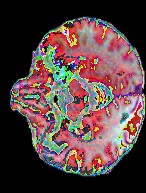

In [ ]:
## visualize input image
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

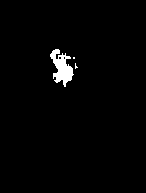

In [ ]:
## visualize input maks
mask_idx = 0
visual_mask = ( inputs['mask_labels'][mask_idx].bool().numpy() * 255 ).astype(np.uint8)
Image.fromarray(visual_mask)

In [ ]:
# peek at the dataset

inputs = val_dataset[3]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(inputs["class_labels"])
# print(inputs)

pixel_values torch.Size([3, 193, 146])
pixel_mask torch.Size([193, 146])
mask_labels torch.Size([2, 193, 146])
class_labels torch.Size([2])
4890
tensor([0, 2])


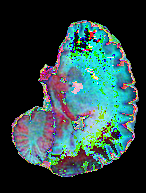

In [ ]:
## visualize input image
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

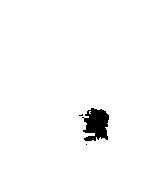

In [ ]:
## visualize input maks
mask_idx = 0
visual_mask = ( inputs['mask_labels'][mask_idx].bool().numpy() * 255 ).astype(np.uint8)
Image.fromarray(visual_mask)

In [ ]:
# setup data loader
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([4, 3, 193, 146])
pixel_mask torch.Size([4, 193, 146])
class_labels 4
mask_labels 4


In [ ]:
batch["pixel_values"][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

### Verify data (!!)

As always, it's very important to check whether the data which we'll feed to the model makes sense. Let's do some sanity checks.

One of them is denormalizing the pixel values to see whether we still get an image that makes sense.

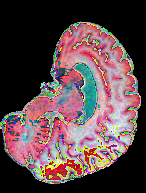

In [ ]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

batch_index = 0

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
batch["mask_labels"][batch_index]

tensor([], size=(0, 193, 146))

In [ ]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Visualizing mask for: else


IndexError: ignored

In [ ]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][1].item()])

visual_mask = (batch["mask_labels"][batch_index][1].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

*In* this case, there are many class labels it seems.

In [ ]:
batch["class_labels"][batch_index]

In [ ]:
for idx in range( batch["class_labels"][batch_index].shape[0]):
    label_id = batch["class_labels"][batch_index][idx].item()
    print("Labels in image:", id2label[label_id])

In [ ]:
batch["class_labels"][batch_index][0].item()

In [ ]:
id2label[batch["class_labels"][batch_index][0].item()]


## 3. Fine-tuning Model

### 3.1 Define the model

In [ ]:
# load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print model config
configuration = model.config
print(configuration)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MaskFormerConfig {
  "_commit_hash": "b569351e060953d37fd7dfb8b16ab83c360a13d6",
  "_name_or_path": "facebook/maskformer-swin-base-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 128,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",

In [ ]:
# load saved model if needed
model = torch.load('model/model_current.pt')

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [ ]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model = model.to(device)
# forward and compute loss
outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print(outputs.loss)


pixel_values torch.Size([4, 3, 193, 146])
pixel_mask torch.Size([4, 193, 146])
class_labels 4
mask_labels 4
[torch.Size([1]), torch.Size([4]), torch.Size([1]), torch.Size([1])]
[torch.Size([0, 193, 146]), torch.Size([4, 193, 146]), torch.Size([0, 193, 146]), torch.Size([0, 193, 146])]
tensor([3.7686], device='cuda:0', grad_fn=<AddBackward0>)


### 3.3 Train the model

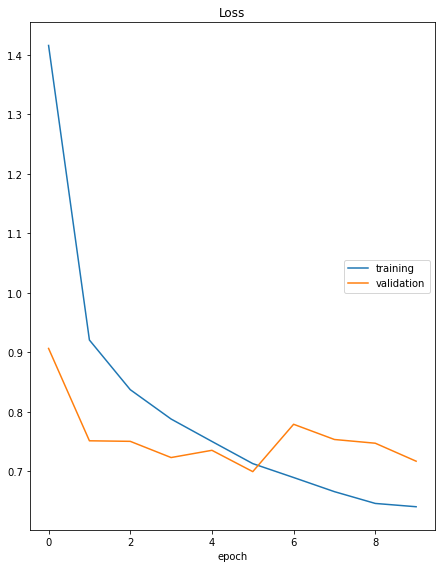

Loss
	training         	 (min:    0.640, max:    1.416, cur:    0.640)
	validation       	 (min:    0.699, max:    0.906, cur:    0.717)


In [ ]:
# training

liveloss = PlotLosses()

if not os.path.exists('model'):
    os.makedirs('model')

n_epoch = 10
batch_max = 10000
loss_train = []
loss_val = []
min_loss = 1e9
# mutiplier is used to scale loss values to be more readable
loss_multiplier = 10.0

lr = 0.2e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)) )
logs = {}
# logs['loss'] = loss_init
# logs['val_loss'] = loss_init

# liveloss.update(logs)
# liveloss.send()

for epoch in range(1,n_epoch+1):
    print("Starting Epoch:", epoch)

    ## training loop
    running_loss = 0.0
    num_samples = 0
    model.train()
    for ibatch, batch in enumerate(tqdm(train_dataloader)):
        # run partial data based on input limit
        if ibatch < batch_max:
            # Reset the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                    pixel_values=batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # Backward propagation
            loss = outputs.loss * loss_multiplier
            loss.backward()

            batch_size = batch["pixel_values"].size(0)
            running_loss += loss.item()
            num_samples += batch_size
            loss_train_cur = running_loss/num_samples

            # Optimization
            optimizer.step()
        else:
            # skip where ibatch >= batch_max
            break

    # record loss at the end of each epoch
    logs['loss'] = loss_train_cur
    print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
    loss_train.append(loss_train_cur)

    ## validation loop
    running_loss = 0.0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for ibatch, batch in enumerate(tqdm(val_dataloader)):
            # run partial data based on input limit
            if ibatch < batch_max:
                # Forward pass
                outputs = model(
                        pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],
                )

                # loss
                loss = outputs.loss  * loss_multiplier

                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
                loss_val_cur = running_loss/num_samples
            else:
                # skip where ibatch >= batch_max
                break

    # record loss at the end of each epoch
    logs['val_loss'] = loss_val_cur
    # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
    loss_val.append(loss_val_cur)

    # if found better model, update min_loss and save model (currently using training loss)
    if min_loss > loss_val_cur:
        print("Saved model in epoch",epoch)
        # save the best model
        torch.save(model, 'model/model_current.pt')
        min_loss = loss_val_cur

    # save model regularly
    if epoch%5 == 0:
        print("Saved model in epoch",epoch)
        # save the best model
        torch.save(model, 'model/model_epoch'+str(epoch)+'.pt')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()

# save loss at the end
torch.save(loss_train, 'model/losses_train_current.pt')
torch.save(loss_val, 'model/losses_val_current.pt')


## 4. Evaluation

### 4.1 Model prediction QC



In [ ]:
train_dataloader_test = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
target_batch = 53

for ibatch, batch in enumerate(train_dataloader_test):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

test_idx = 0

test_image      =  test_batch["pixel_values"][test_idx]
test_pixel_mask =  test_batch["pixel_mask"][test_idx]
test_mask_label =  test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]

print(test_image.shape)
print(test_pixel_mask.shape)
print(test_mask_label.shape)
print(test_class_labels)

pixel_values torch.Size([4, 3, 193, 146])
pixel_mask torch.Size([4, 193, 146])
class_labels 4
mask_labels 4
torch.Size([3, 193, 146])
torch.Size([193, 146])
torch.Size([4, 193, 146])
tensor([0, 1, 2, 4])


(3, 193, 146)


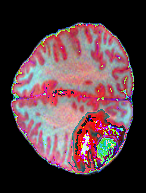

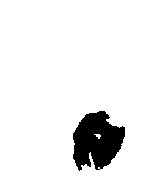

In [ ]:
# Visualize input data

import torchvision.transforms as transforms

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

print( np.array(test_image).shape )

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

## visualize input maks
mask_idx = 0
visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255 ).astype(np.uint8)
Image.fromarray(visual_mask)

# display the image and segmentation
display( Image.fromarray(unnormalized_image))

display( Image.fromarray(visual_mask) )


In [ ]:
processor_test = MaskFormerImageProcessor()

inputs = processor_test(transforms.ToPILImage()(test_image), return_tensors="pt").to(device)

for k,v in inputs.items():
  print(k,v.shape)

# forward pass
with torch.no_grad():
  outputs = model(**inputs)

del inputs
torch.cuda.empty_cache()

# obtain results
results = processor_test.post_process_instance_segmentation(outputs, target_sizes=[transforms.ToPILImage()(test_image).size[::-1]])[0]
print(results['segments_info'])


pixel_values torch.Size([1, 3, 1088, 800])
pixel_mask torch.Size([1, 1088, 800])
[{'id': 1, 'label_id': 2, 'was_fused': False, 'score': 0.998608}, {'id': 2, 'label_id': 0, 'was_fused': False, 'score': 0.9974}]


In [ ]:
results['segmentation'].shape

torch.Size([193, 146])

In [ ]:
# Obtain labels in true, predict, intersection and union

labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )
# remove duplicates
labels_pred = list(set(labels_pred))

labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:",labels_all)
print("Common labels:",labels_common)

True labels: ['else', 'NCR', 'ED', 'ET']
Predicted labels: ['ED', 'else']
All labels: ['NCR', 'ET', 'ED', 'else']
Common labels: ['ED', 'else']


In [ ]:
label2id = {}
for key, value in id2label.items():
    label2id[value] = key

Visualizing mask for instance: ED
label_id is: 2


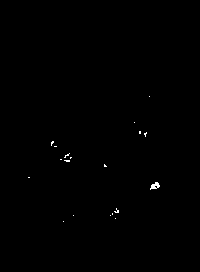

Visualizing mask for instance: else
label_id is: 0


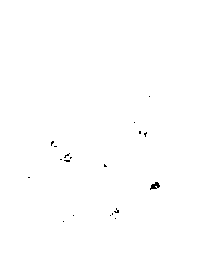

In [ ]:
# visual QC predicted masks
for label in labels_pred:
    mask_pred = np.zeros((results['segmentation'].shape[0],results['segmentation'].shape[1]))

    # find information in results
    id = label2id[label]
    for item in results['segments_info']:
        if item['label_id'] == id:
            segment = item
            mask_pred += np.array( get_mask(results['segmentation'], segment['id']) )
    mask_pred = mask_pred.astype(np.uint8)

    print("Visualizing mask for instance:", id2label[id])
    print("label_id is:", id )

    # display masks
    display(Image.fromarray(mask_pred))

Visualizing mask for instance: else
label_id is: 0


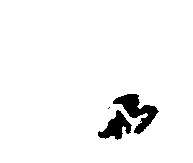

Visualizing mask for instance: NCR
label_id is: 1


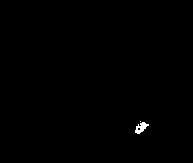

Visualizing mask for instance: ED
label_id is: 2


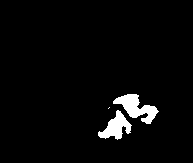

Visualizing mask for instance: ET
label_id is: 4


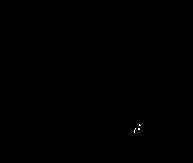

In [ ]:
# visual true masks
for label in labels_true:
    # obtain true mask
    id = label2id[label]
    idx = [0,1,2,4].index(id)
    mask = test_mask_label[idx,:,:].numpy()
    mask_true = (mask * 255).astype(np.uint8)

    print("Visualizing mask for instance:", id2label[id])
    print("label_id is:", id )

    # display masks
    display(Image.fromarray(mask_true))

## Back-up